### a) Imports

In [1]:
import matplotlib.pyplot as plt
from sklearn import linear_model, datasets
import os
import simplejson
import sys
import numpy as np
from sklearn.datasets import load_svmlight_file

import loss_functions, make_plots
import scr, tr, gradient_methods, saga    
import torch

### b) load data and initialize weights

In [2]:
#####################
#### Load  Data  ####
#####################

dataset_name='a9a' 

#logistic regression:
if dataset_name=='a9a':
    X, Y = load_svmlight_file('data/a9a')
    X = X.toarray()
    Y= [0 if e == -1 else e for e in Y]
    Y=np.array(Y)      
    d = X.shape[1]
    n = X.shape[0]
    w = np.zeros(d)
    
#multinominal (softmax) regression:
elif dataset_name == 'mnist':
    import scipy 
    X, Y = load_svmlight_file('data/mnist')
    X = X.toarray()
    nC = len(np.unique(Y))    
    ## one-hot encoding of labels
    data   = np.ones(len(Y))
    indptr = np.arange(len(Y)+1)
    ground_truth = scipy.sparse.csr_matrix((data, Y, indptr))
    Y = ground_truth.todense() #gives a matrix with [Ground_Truth]i,j: is sample i in class j? (n x nC)
    d = X.shape[1]
    n = X.shape[0]
    w = np.zeros(nC*d)

#general function    
elif dataset_name=='rosenbrock':
    d=2
    n=1 
    w = np.zeros(d)

if not isinstance(X,torch.tensor._TensorBase):
    X = torch.from_numpy(X)
if not isinstance(Y,torch.tensor._TensorBase):
    Y = torch.from_numpy(Y)
if not isinstance(w,torch.tensor._TensorBase):
    w = torch.from_numpy(w)

print ('Dataset', dataset_name, 'loaded')    
print ('n = ' + str(n) + ' d = ' + str(d))

Dataset a9a loaded
n = 32561 d = 123


### c) specify a loss, gradient, Hessian-vector-product and Hessian computations
- (latter only needed for hard case)
- functions need to have (w,X,Y,kwargs...) as input structure !

In [3]:
class NumPyWrapper:
    def __init__(self,loss,gradient,Hv,Hessian,loss_args={}):
        self.loss_numpy = loss
        self.gradient_numpy = gradient
        self.Hv_numpy = Hv
        self.Hessian_numpy = Hessian
        self.loss_args = loss_args
        
    def loss(self,w,X,Y,**kwargs):
        return float(self.loss_numpy(w.numpy(),X.numpy(),Y.numpy(),**self.loss_args))
    
    def gradient(self,w,X,Y,**kwargs):
        return torch.from_numpy(self.gradient_numpy(w.numpy(),X.numpy(),Y.numpy(),**self.loss_args))
    
    def Hv(self,w,X,Y,v,**kwargs):
        return torch.from_numpy(self.Hv_numpy(w.numpy(),X.numpy(),Y.numpy(),v.numpy(),**self.loss_args))
    
    def Hessian(self,w,X,Y,**kwargs):
        return torch.from_numpy(self.Hessian_numpy(w.numpy(),X.numpy(),Y.numpy(),**self.loss_args))
    
if dataset_name in {'a9a'}:
    loss_computation_numpy = loss_functions.logistic_loss
    gradient_computation_numpy = loss_functions.logistic_loss_gradient
    hessian_vector_computation_numpy = loss_functions.logistic_loss_Hv
    hessian_computation_numpy = loss_functions.logistic_loss_hessian
        # Additional arguments that are to be passed to the Loss, Gradient, etc. computations
    loss_args= {}
    loss_args['alpha'] = 1e-3 # regularizer

    wrapper = NumPyWrapper(
        loss_computation_numpy,
        gradient_computation_numpy,
        hessian_vector_computation_numpy,
        hessian_computation_numpy,
        loss_args=loss_args)
    loss_computation = wrapper.loss
    gradient_computation = wrapper.gradient
    hessian_vector_computation = wrapper.Hv
    hessian_computation = wrapper.Hessian

if dataset_name in {'mnist'}:
    loss_computation = loss_functions.softmax_loss
    gradient_computation = loss_functions.softmax_loss_gradient
    hessian_vector_computation = loss_functions.softmax_loss_Hv
    hessian_computation = loss_functions.softmax_loss_hessian
    
    loss_args= {}
    loss_args['alpha'] = 1e-3
    loss_args['n_classes'] = nC # for multiclass (softmax) regression
    
    wrapper = NumPyWrapper(
        loss_computation_numpy,
        gradient_computation_numpy,
        hessian_vector_computation_numpy,
        hessian_computation_numpy,
        loss_args=loss_args)
    loss_computation = wrapper.loss
    gradient_computation = wrapper.gradient
    hessian_vector_computation = wrapper.Hv
    hessian_computation = wrapper.Hessian
    

    
elif dataset_name == 'rosenbrock':
    loss_computation_numpy = loss_functions.rosenbrock_loss
    gradient_computation_numpy = loss_functions.rosenbrock_gradient
    hessian_vector_computation_numpy = loss_functions.rosenbrock_Hv
    hessian_computation_numpy = loss_functions.rosenbrock_hessian
    
    wrapper = NumPyWrapper(
        loss_computation_numpy,
        gradient_computation_numpy,
        hessian_vector_computation_numpy,
        hessian_computation_numpy)
    loss_computation = wrapper.loss
    gradient_computation = wrapper.gradient
    hessian_vector_computation = wrapper.Hv
    hessian_computation = wrapper.Hessian
    
    loss_args= {}

In [4]:
def show_plots(x_limits_time=None):
    list_params=[]
    list_loss=[]
    list_x=[]
    list_samples=[]
    
    log_scale=True
    
    over_time=True
    over_iterations=True
    over_epochs=True
    
    if SCR:
        list_loss.append(SCR_loss)
        list_x.append(SCR_x)
        list_samples.append(SCR_samples)
        list_params.append('SCR')
        
    if TR:
        list_loss.append(TR_loss)
        list_x.append(TR_x)
        list_samples.append(TR_samples)
        list_params.append('TR')
        
    if SGD:
        list_loss.append(SGD_loss)
        list_x.append(SGD_x)
        list_samples.append(SGD_samples)
        list_params.append('SGD')
    if SAGA:
        list_loss.append(SAGA_loss)
        list_x.append(SAGA_x)
        list_samples.append(SAGA_samples)
        list_params.append('SAGA')
        
    if over_time:
        make_plots.two_d_plot_time(list_loss,list_x,list_params,dataset_name, n, d, log_scale,x_limits=x_limits_time)
        
    if over_iterations:
        make_plots.two_d_plot_iterations(list_loss,list_x,list_params,dataset_name, n, d, log_scale)
        
    if over_epochs:
        make_plots.two_d_plot_epochs(list_loss,list_samples,list_params,dataset_name, n, d, log_scale)


### d) Set parameters and run methods

In [5]:
n_runs = 1 # repeat experiments to lower effect of randomness

# The following parameters are optional in the sense that default values are set if not specified.

#options common to all algorithms
opt = {}
opt['grad_tol'] = 1e-9

#common to tr and scr
opt_tr = dict(opt)
opt_tr['penalty_increase_multiplier']=2.    # multiply by..
opt_tr['penalty_derease_multiplier']=2.     # divide by..

### TR and SCR:
opt_tr['max_iterations'] = 20
opt_tr['sample_size_scheme'] = 'exponential'#alternatives constant,linear,exponential,adaptive
#scaling matrix/M-norm. alternatives have specific parameters, see source code
opt_tr['scaling_matrix'] = 'uniform'#alternatives adagrad,rmsprop,adadelta,approximate_hessian_diagonal,GGT
opt_tr['successful_treshold']=0.1
opt_tr['very_successful_treshold']=0.9
# Sampling
opt_tr['Hessian_sampling']=True
opt_tr['gradient_sampling']=False
opt_tr['unsuccessful_sample_scaling']=1.5
opt_tr['sample_scaling_Hessian']=1
opt_tr['sample_scaling_gradient']=1
opt_tr['krylov_tol']=1e-1
opt_tr['exact_tol']=1e-7
opt_tr['initial_sample_size_Hessian']=0.025*n
opt_tr['initial_sample_size_gradient']=0.25*n

opt_scr = dict(opt_tr)

#tr only
opt_tr['initial_trust_radius']=1.0
opt_tr['subproblem_solver']='GLTR' # alternatives: GLTR, cauchy, CG (implements Steihaug-CG), without GPU and scaling support: exact, dog_leg,

#scr only
opt_scr['initial_penalty']=0.01
opt_scr['subproblem_solver']='lanczos' # alternatives: lanczos, cauchy, exact
opt_scr['solve_each_i-th_krylov_space']=1 #===1 in TR
opt_scr['keep_Q_matrix_in_memory']=True #===True in TR

### SGD:
opt_sgd = dict(opt)
opt_sgd['method_name']='SGD'
opt_sgd['max_epochs']=9
opt_sgd['learning_rate']=1e-1 # This SGD implementation expects a constant step size
opt_sgd['batch_size']=0.001*n
opt_sgd['replacement']=True #False slows down sampling 

### SAGA:
opt_saga = {}
opt_saga['n_epochs_saga']=10
opt_saga['learning_rate_saga']=1e-2



######################
#### Run Methods #####
######################

SCR= True
TR= True
SGD= False
SAGA= False

# If running on GPU and profile==True, make sure that CUDA_LAUNCH_BLOCKING=1
# is set in the environment, otherwise the results of the profiler will be bogus.
profile = True 
if profile:
    import cProfile, pstats, io
    pr = cProfile.Profile()
    pr.enable()
    
    
if SCR:
    loss_collector=[]
    timings_collector=[]
    samples_collector=[]
    
    for k in range(n_runs): 
        SCR_loss=[]
        SCR_x=[]
        (w_SCR, _s)=scr.SCR(w,loss_computation,gradient_computation,
                                                Hv=hessian_vector_computation,hessian=hessian_computation,
                                                X=X, Y=Y, opt=opt_scr, **loss_args)
        loss_collector.append(_s['loss'])
        timings_collector.append(_s['time'])
        samples_collector.append(_s['samples'])

    SCR_loss = [float(sum(col))/len(col) for col in zip(*loss_collector)]
    SCR_x = [float(sum(col))/len(col) for col in zip(*timings_collector)]    
    SCR_samples= [float(sum(col))/len(col) for col in zip(*samples_collector)] 
    
if TR:
    loss_collector=[]
    timings_collector=[]
    samples_collector=[]
    for k in range(n_runs): 
        TR_loss=[]
        TR_x=[]
        (w_TR,_s)=tr.Trust_Region(w,loss_computation,gradient_computation,
                                                      Hv=hessian_vector_computation, hessian=hessian_computation,
                                                      X=X, Y=Y, opt=opt_tr,**loss_args)
        loss_collector.append(_s['loss'])
        timings_collector.append(_s['time'])
        samples_collector.append(_s['samples'])
        
    TR_loss = [float(sum(col))/len(col) for col in zip(*loss_collector)]
    TR_x = [float(sum(col))/len(col) for col in zip(*timings_collector)]    
    TR_samples= [float(sum(col))/len(col) for col in zip(*samples_collector)] 
    
if SGD:
    loss_collector=[]
    timings_collector=[]
    samples_collector=[]
    
    for k in range(n_runs): 
        SGD_loss=[]
        SGD_x=[]
        (w_SGD,_s)=gradient_methods.Gradient_Method(w,loss_computation,gradient_computation, X=X, Y=Y, opt=opt_sgd, **loss_args)
        loss_collector.append(_s['loss'])
        timings_collector.append(_s['time'])
        samples_collector.append(_s['samples'])

    SGD_loss = [float(sum(col))/len(col) for col in zip(*loss_collector)]
    SGD_x = [float(sum(col))/len(col) for col in zip(*timings_collector)]    
    SGD_samples= [float(sum(col))/len(col) for col in zip(*samples_collector)]
    
if SAGA:
    loss_collector=[]
    timings_collector=[]
    samples_collector=[]
    
    for k in range(n_runs): 
        SAGA_loss=[]
        SAGA_x=[]
        (w_SAGA,_s)=saga.SAGA(w,loss_computation_numpy,gradient_computation_numpy, X=X, Y=Y, opt=opt_saga, **loss_args)
        loss_collector.append(_s['loss'])
        timings_collector.append(_s['time'])
        samples_collector.append(_s['samples'])

    SAGA_loss = [float(sum(col))/len(col) for col in zip(*loss_collector)]
    SAGA_x = [float(sum(col))/len(col) for col in zip(*timings_collector)]    
    SAGA_samples= [float(sum(col))/len(col) for col in zip(*samples_collector)] 
if profile:
    pr.disable()
    s = io.StringIO()
    sortby = 'cumulative'
    ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
    ps.print_stats()
    print(s.getvalue())

--- Subsampled Cubic Regularization ---

cardinality of dataset n = 32561
dimension of parameter space d = 123


SCR configuration:

* (outer) termination criteria 
   - max_iterations: 20
   - grad_tol: 1e-09

* trust region adaption parameters:
   - initial_penalty: 0.01
   - min_penalty: 0.0
   - successful_threshold: 0.1
   - very_successful_threshold: 0.9
   - penalty_increase_multiplier: 2.0
   - penalty_decrease_multiplier: 2.0
   - accept_all_decreasing_steps: True

* subsolver and related parameters:
   - subsolver: lanczos
   - krylov_tol: 0.1
   - exact_tol: 1e-07
   - lanczos_termination_criterion: g
   - solve_each_i_th_krylov_space: 1
   - keep_Q_matrix_in_memory: True

* trust region shape and related parameters:
   - scaling_matrix:  uniform

* sampling parameters:
   - replacement: False
   - sampling_scheme: independent
   - Hessian_sampling_flag: True
   - initial_sample_size_Hessian: 814
   - gradient_sampling_flag: False
   - loss_sampling_flag: False

* sampling s

Interior point after 6 iterations
Iter 3: loss=0.33367018183055596747 ||g||=1.771e-02 time=1.140900e-01 dt=4.674e-02 tr_radius=4.000e+00
        ||s||=8.242e-01 ||s||_M=8.242e-01 samples Hessian= 817 samples gradient= 32561 samples loss= 32561
        epoch=4.100e+00 rho=9.889744e-01 accepted= True successful=True 

Interior point after 10 iterations
Iter 4: loss=0.33338604850026382076 ||g||=4.158e-03 time=1.346690e-01 dt=2.058e-02 tr_radius=4.000e+00
        ||s||=4.826e-01 ||s||_M=4.826e-01 samples Hessian= 820 samples gradient= 32561 samples loss= 32561
        epoch=5.125e+00 rho=7.475946e-01 accepted= True successful=True 

Interior point after 14 iterations
Iter 5: loss=0.33334434393016271203 ||g||=1.208e-03 time=1.617190e-01 dt=2.705e-02 tr_radius=4.000e+00
        ||s||=1.514e-01 ||s||_M=1.514e-01 samples Hessian= 826 samples gradient= 32561 samples loss= 32561
        epoch=6.151e+00 rho=8.663730e-01 accepted= True successful=True 

Interior point after 14 iterations
Iter 6: l

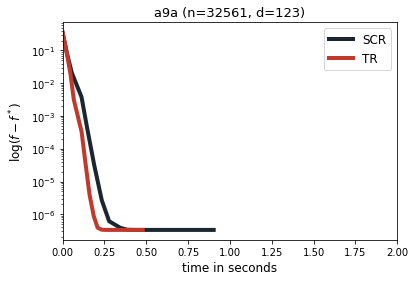

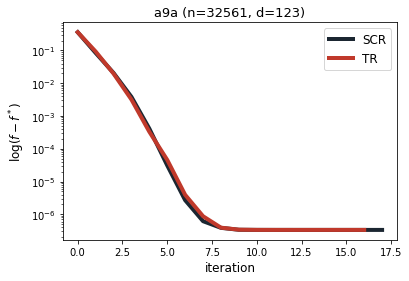

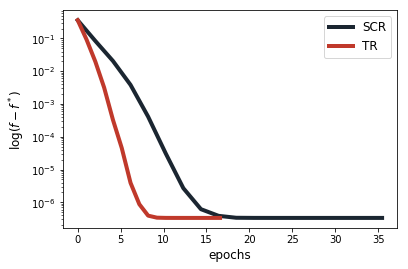

In [6]:
%matplotlib inline
show_plots(x_limits_time=(0,2))

In [7]:
import models
n_runs = 1 

n_runs = 1 # repeat experiments to lower effect of randomness

# The following parameters are optional in the sense that default values are set if not specified.

#options common to all algorithms
opt = {}
opt['grad_tol'] = 1e-9

#common to tr and scr
opt_tr = dict(opt)
opt_tr['penalty_increase_multiplier']=2.    # multiply by..
opt_tr['penalty_derease_multiplier']=2.     # divide by..

### TR and SCR:
opt_tr['max_iterations'] = 20
opt_tr['sample_size_scheme'] = 'exponential'#alternatives constant,linear,exponential,adaptive
#scaling matrix/M-norm. alternatives have specific parameters, see source code
opt_tr['scaling_matrix'] = 'uniform'#alternatives adagrad,rmsprop,adadelta,approximate_hessian_diagonal,GGT
opt_tr['successful_treshold']=0.1
opt_tr['very_successful_treshold']=0.9
# Sampling
opt_tr['Hessian_sampling']=True
opt_tr['gradient_sampling']=False
opt_tr['unsuccessful_sample_scaling']=1.5
opt_tr['sample_scaling_Hessian']=1
opt_tr['sample_scaling_gradient']=1
opt_tr['krylov_tol']=1e-1
opt_tr['exact_tol']=1e-7

opt_scr = dict(opt_tr)

#tr only
opt_tr['initial_sample_size_Hessian']=0.025*n
opt_tr['initial_sample_size_gradient']=0.25*n
opt_tr['initial_trust_radius']=1.0
opt_tr['subproblem_solver']='GLTR' # alternatives: GLTR, cauchy, CG (implements Steihaug-CG), without GPU and scaling support: exact, dog_leg,

#scr only
opt_scr['initial_sample_size_Hessian']=0.025*n
opt_scr['initial_sample_size_gradient']=0.25*n
opt_scr['initial_penalty']=0.01
opt_scr['subproblem_solver']='lanczos' # alternatives: lanczos, cauchy, exact
opt_scr['solve_each_i-th_krylov_space']=1 #===1 in TR
opt_scr['keep_Q_matrix_in_memory']=True #===True in TR

### SGD:
opt_sgd = dict(opt)
opt_sgd['method_name']='SGD'
opt_sgd['max_epochs']=9
opt_sgd['learning_rate']=1e-1 # This SGD implementation expects a constant step size
opt_sgd['batch_size']=0.001*n
opt_sgd['replacement']=True #False slows down sampling 

### SAGA:
opt_saga = {}
opt_saga['n_epochs_saga']=10
opt_saga['learning_rate_saga']=1e-2

dataset_name = 'mnist-c' # try: 'a9a','mnist-c','mnist-a','cifar-c'

if dataset_name=='a9a':
    X, Y = load_svmlight_file('data/a9a')
    X = X.toarray()
    Y= [0 if e == -1 else e for e in Y]
    Y=np.array(Y)      
    d = X.shape[1]
    n = X.shape[0]
    X = torch.from_numpy(X)
    Y = torch.from_numpy(Y).long()
    X_valid = X[:25000]
    Y_valid = Y[:25000]
    X = X[25000:]
    Y = Y[25000:]
    
    net=torch.nn.Linear(d,2,bias=False)
    loss = torch.nn.CrossEntropyLoss()
    
if dataset_name=='mnist-c':
    import torchvision
    trainset = torchvision.datasets.MNIST("./data/",download=True,train=True)
    testset = torchvision.datasets.MNIST("./data/",download=True,train=False)
    X = [torchvision.transforms.ToTensor()(s[0]) for s in trainset]
    X = torch.cat(X).view(-1,28*28)
    Y = torch.cat([torch.LongTensor([s[1]]) for s in trainset])
    X_valid = [torchvision.transforms.ToTensor()(s[0]) for s in testset]
    X_valid = torch.cat(X_valid).view(-1,28*28)
    Y_valid = torch.cat([torch.LongTensor([s[1]]) for s in testset])
    #torch.cat([torch.LongTensor([s[1]]) for s in testset])
    n = 60000
    net = models.OneHiddenLayer(nonlinearity_hidden=torch.nn.Softplus(),nonlinearity_out=torch.nn.Sigmoid(),d_in=28*28,d_hidden=100,d_out=10)
    loss = torch.nn.CrossEntropyLoss()
    
if dataset_name=='mnist-a':
    import torchvision
    trainset = torchvision.datasets.MNIST("./data/",download=True,train=True)
    testset = torchvision.datasets.MNIST("./data/",download=True,train=False)
    X = [torchvision.transforms.ToTensor()(s[0]) for s in trainset]
    X = torch.cat(X).view(-1,28*28)
    Y = X
    X_valid = [torchvision.transforms.ToTensor()(s[0]) for s in testset]
    X_valid = torch.cat(X_valid).view(-1,28*28)
    Y_valid = X_valid
    n = len(trainset)
    net = models.MNISTAutoencoder()
    loss = lambda output,Y:torch.mean((output-Y)**2)#torch.nn.MSELoss has a bug for float on cpu
    
if dataset_name=='cifar-c':
    import torchvision
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
    n = len(trainset)
    X = [None]*len(trainset)
    Y = [None]*len(trainset)
    for i in range(len(trainset)):
        (picture,label) = trainset[i]
        X[i] = torchvision.transforms.ToTensor()(picture)
        Y[i] = torch.LongTensor([label])
    X = torch.cat(X).view(-1,3,32,32)
    tmp = [torch.LongTensor([s[1]]) for s in trainset]
    Y = torch.cat(tmp)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)
    X_valid = [torchvision.transforms.ToTensor()(s[0]) for s in testset]
    X_valid = torch.cat(X_valid).view(-1,3,32,32)
    Y_valid = torch.cat([torch.LongTensor([s[1]]) for s in testset])

    net = models.CIFAR10WithSoftPlus()
    loss = torch.nn.CrossEntropyLoss()

import loss_functions
wrapper = loss_functions.PyTorchWrapper(net, loss, l2_reg = 0.0, on_gpu=False)
loss_computation = wrapper.forward
gradient_computation = wrapper.gradient
hessian_vector_computation = wrapper.Hv_store_gradient
hessian_computation = wrapper.hessian
finite_difference = False # False,'forward','central'/True

if finite_difference:
    delta_fd = 1e-6
    if finite_difference == 'forward':
        def fdHv(w,X,Y,v,**kwargs):
            if wrapper.evaluate_gradient_for_hv:
                mid = gradient_computation(w,X,Y,**kwargs)
                wrapper.evaluate_gradient_for_hv = False
            r = gradient_computation(w+delta_fd*v,X,Y,**kwargs)
            return (r-mid)/delta_fd
    else:
        def fdHv(w,X,Y,v,**kwargs):
            l = gradient_computation(w-delta_fd*v,X,Y,**kwargs)
            r = gradient_computation(w+delta_fd*v,X,Y,**kwargs)
            return (r-l)/(2*delta_fd)
    hessian_vector_computation = fdHv


d = wrapper.d
w = X.new(d).zero_()

TR=True
SCR=True
SGD=True

def validation_loss(i,w,s):
    validation_loss = wrapper.forward(w,X_valid,Y_valid)
    print('Validation loss:',validation_loss)
    if i==0:
        s['validation_loss'] = []
    s['validation_loss'].append(validation_loss)
if SCR:
    loss_collector=[]
    timings_collector=[]
    samples_collector=[]
    
    for k in range(n_runs): 
        SCR_loss=[]
        SCR_x=[]
        (w_SCR, _s)=scr.SCR(w,loss_computation,gradient_computation,
                                                Hv=hessian_vector_computation,hessian=hessian_computation,
                                                X=X, Y=Y, opt=opt_scr, **loss_args)
        loss_collector.append(_s['loss'])
        timings_collector.append(_s['time'])
        samples_collector.append(_s['samples'])

    SCR_loss = [float(sum(col))/len(col) for col in zip(*loss_collector)]
    SCR_x = [float(sum(col))/len(col) for col in zip(*timings_collector)]    
    SCR_samples= [float(sum(col))/len(col) for col in zip(*samples_collector)] 
if TR:
    loss_collector=[]
    timings_collector=[]
    sampfles_collector=[]
    for k in range(n_runs): 
        TR_loss=[]
        TR_x=[]
        (w_TR,_s)=tr.Trust_Region(w,loss_computation,gradient_computation,
                                                      Hv=hessian_vector_computation, hessian=hessian_computation,
                                                      X=X, Y=Y,opt=opt_tr, statistics_callback = validation_loss)
        loss_collector.append(_s['loss'])
        timings_collector.append(_s['time'])
        samples_collector.append(_s['samples'])
        
    TR_loss = [float(sum(col))/len(col) for col in zip(*loss_collector)]
    TR_x = [float(sum(col))/len(col) for col in zip(*timings_collector)]    
    TR_samples= [float(sum(col))/len(col) for col in zip(*samples_collector)] 
    
if SGD:
    loss_collector=[]
    timings_collector=[]
    samples_collector=[]
    
    for k in range(n_runs): 
        SGD_loss=[]
        SGD_x=[]
        (w_SGD,_s)=gradient_methods.Gradient_Method(w,loss_computation,gradient_computation, X=X, Y=Y, opt=opt_sgd, statistics_callback = validation_loss)
        loss_collector.append(_s['loss'])
        timings_collector.append(_s['time'])
        samples_collector.append(_s['samples'])

    SGD_loss = [float(sum(col))/len(col) for col in zip(*loss_collector)]
    SGD_x = [float(sum(col))/len(col) for col in zip(*timings_collector)]    
    SGD_samples= [float(sum(col))/len(col) for col in zip(*samples_collector)]

--- Subsampled Cubic Regularization ---

cardinality of dataset n = 60000
dimension of parameter space d = 79510


SCR configuration:

* (outer) termination criteria 
   - max_iterations: 20
   - grad_tol: 1e-09

* trust region adaption parameters:
   - initial_penalty: 0.01
   - min_penalty: 0.0
   - successful_threshold: 0.1
   - very_successful_threshold: 0.9
   - penalty_increase_multiplier: 2.0
   - penalty_decrease_multiplier: 2.0
   - accept_all_decreasing_steps: True

* subsolver and related parameters:
   - subsolver: lanczos
   - krylov_tol: 0.1
   - exact_tol: 1e-07
   - lanczos_termination_criterion: g
   - solve_each_i_th_krylov_space: 1
   - keep_Q_matrix_in_memory: True

* trust region shape and related parameters:
   - scaling_matrix:  uniform

* sampling parameters:
   - replacement: False
   - sampling_scheme: independent
   - Hessian_sampling_flag: True
   - initial_sample_size_Hessian: 814
   - gradient_sampling_flag: False
   - loss_sampling_flag: False

* sampling

Validation loss: 2.302700996398926
Boundary point after 3 iterations
Iter 0: loss=2.29565834999084472656 ||g||=2.972e-02 time=2.118169e+00 dt=2.118e+00 tr_radius=1.000e+00
        ||s||=1.000e+00 ||s||_M=1.000e+00 samples Hessian= 814 samples gradient= 60000 samples loss= 60000
        epoch=1.014e+00 rho=5.924859e-01 accepted= True successful=True 

Validation loss: 2.294743776321411
Boundary point after 3 iterations
Iter 1: loss=2.29565834999084472656 ||g||=3.355e-02 time=4.296240e+00 dt=2.178e+00 tr_radius=1.000e+00
        ||s||=1.000e+00 ||s||_M=1.000e+00 samples Hessian= 814 samples gradient= 60000 samples loss= 60000
        epoch=2.027e+00 rho=-7.786613e-02 accepted= False successful=False 

Validation loss: 2.294743776321411
Boundary point after 3 iterations
Iter 2: loss=2.29332518577575683594 ||g||=3.355e-02 time=5.129042e+00 dt=8.328e-01 tr_radius=5.000e-01
        ||s||=5.000e-01 ||s||_M=5.000e-01 samples Hessian= 816 samples gradient= 60000 samples loss= 60000
        epoc

Epoch 3: loss=1.87814784049987792969 ||g||=1.270e-01 time=3.045331e+01 dt=7.638e+00 ||s||=1.270e-02
Validation loss: 1.8744823932647705
Epoch 4: loss=1.85191690921783447266 ||g||=9.953e-02 time=3.811897e+01 dt=7.666e+00 ||s||=9.953e-03
Validation loss: 1.8487913608551025
Epoch 5: loss=1.83547031879425048828 ||g||=1.487e-01 time=4.681825e+01 dt=8.699e+00 ||s||=1.487e-02
Validation loss: 1.8327395915985107
Epoch 6: loss=1.82426691055297851562 ||g||=1.356e-01 time=5.561686e+01 dt=8.799e+00 ||s||=1.356e-02
Validation loss: 1.8217244148254395
Epoch 7: loss=1.81594061851501464844 ||g||=1.441e-01 time=6.480166e+01 dt=9.185e+00 ||s||=1.441e-02
Validation loss: 1.8138179779052734
Epoch 8: loss=1.80992281436920166016 ||g||=1.588e-01 time=7.383597e+01 dt=9.034e+00 ||s||=1.588e-02
Validation loss: 1.8079029321670532
Terminating due to epoch limit


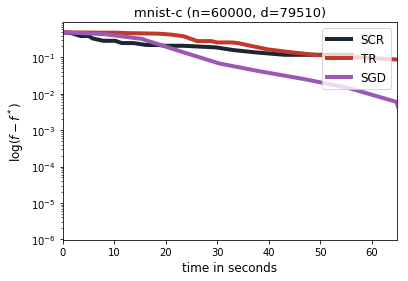

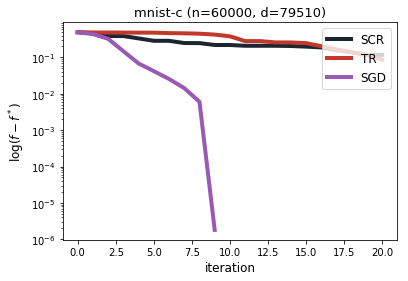

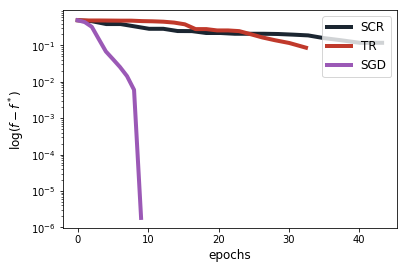

In [11]:

%matplotlib inline
show_plots(x_limits_time=(0,65))

In [13]:
_s['validation_loss']

[2.302700996398926,
 2.2455880641937256,
 2.1317577362060547,
 1.9522939920425415,
 1.8744823932647705,
 1.8487913608551025,
 1.8327395915985107,
 1.8217244148254395,
 1.8138179779052734,
 1.8079029321670532]